Прогнозирование TimeGrad регулярных временных рядов.

## Imports

In [15]:
import os
from google.colab import drive

drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/gen_models')

os.listdir('./')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['reports', 'exp.txt', 'pytorch-ts', 'requirements.txt']

In [17]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 35.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed

In [18]:
!pip install pandas==1.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 33.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.0
    Uninstalling pandas-2.2.0:
      Successfully uninstalled pandas-2.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [1]:
import json
import pickle
import sys

sys.path.append('../pytorch-ts')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from diffusers import DEISMultistepScheduler
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import  get_dataset
from gluonts.evaluation import MultivariateEvaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from pts.model.time_grad import TimeGradEstimator

/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/dataset/artificial/_base.py:84: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.freq: BaseOffset = to_offset(freq)


## Read Datasets

In [10]:
exchange = get_dataset("exchange_rate", regenerate=False)

solar = get_dataset("solar_nips", regenerate=False)

electricity = get_dataset("electricity_nips", regenerate=False)

In [15]:
# electricity
electricity_train_grouper = MultivariateGrouper(
    max_target_dim=min(2000, int(electricity.metadata.feat_static_cat[0].cardinality))
    )

electricity_test_grouper = MultivariateGrouper(
    num_test_dates=int(len(electricity.test) / len(electricity.train)),
    max_target_dim=min(2000, int(electricity.metadata.feat_static_cat[0].cardinality))
    )

# solar
solar_train_grouper = MultivariateGrouper(
    max_target_dim=min(2000, int(solar.metadata.feat_static_cat[0].cardinality))
    )

solar_test_grouper = MultivariateGrouper(
    num_test_dates=int(len(solar.test) / len(solar.train)),
    max_target_dim=min(2000, int(solar.metadata.feat_static_cat[0].cardinality))
    )

# exchange
exchange_train_grouper = MultivariateGrouper(
    max_target_dim=min(2000, int(exchange.metadata.feat_static_cat[0].cardinality))
    )

exchange_test_grouper = MultivariateGrouper(
    num_test_dates=int(len(exchange.test) / len(exchange.train)),
    max_target_dim=min(2000, int(exchange.metadata.feat_static_cat[0].cardinality))
    )

In [20]:
# solar
solar_dataset_train = solar_train_grouper(solar.train)
solar_dataset_test = solar_test_grouper(solar.test)

# electricity
electricity_dataset_train = electricity_train_grouper(electricity.train)
electricity_dataset_test = electricity_test_grouper(electricity.test)

# exchange
exchange_dataset_train = exchange_train_grouper(exchange.train)
exchange_dataset_test = exchange_test_grouper(exchange.test)

/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/dataset/common.py:262: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.Period(val, freq)
/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/dataset/common.py:262: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  return pd.Period(val, freq)
/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/dataset/multivariate_grouper.py:113: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  timestamp + len(data[FieldName.TARGET]) - 1,
/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/dataset/multivariate_grouper.py:242: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex

In [40]:
def plot(
    target,
    forecast,
    prediction_length,
    prediction_intervals=(50.0, 90.0),
    color="g",
    fname=None,
):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape

    ps = [50.0] + [
        50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
    ]

    percentiles_sorted = sorted(set(ps))

    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3

    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)

        ps_data = [forecast.quantile(p / 100.0)[:, dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2

        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)

        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]
    axx[0].legend(legend, loc="upper left")

    if fname is not None:
        plt.savefig(fname, bbox_inches="tight", pad_inches=0.05)


## Train models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Electricity

#### Train

In [91]:
# init scheduler
scheduler = DEISMultistepScheduler(num_train_timesteps=150, beta_end=0.1)

# init estimator
estimator = TimeGradEstimator(
    input_size=int(electricity.metadata.feat_static_cat[0].cardinality),
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=100,
    prediction_length=electricity.metadata.prediction_length,
    context_length=electricity.metadata.prediction_length,
    freq=electricity.metadata.freq,
    scaling="mean",
    trainer_kwargs=dict(max_epochs=200, accelerator="gpu", devices="1"),
)

# train
predictor = estimator.train(
    electricity_dataset_train,
    cache_data=True,
    shuffle_buffer_length=1024
  )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type          | Params | In sizes                                                             | Out sizes        
-----------------------------------------------------------------------------------------------------------------------------------
0 | model | TimeGradModel | 432 K  | [[1, 1], [1, 1], [1, 24, 5], [1, 24, 370], [1, 24, 370], [1, 24, 5]] | [1, 100, 24, 370]
-----------------------------------------------------------------------------------------------------------------------------------
432 K     Trainable pa

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.39031 (best 0.39031), saving model to '/content/drive/MyDrive/lightning_logs/version_6/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 0.22343 (best 0.22343), saving model to '/content/drive/MyDrive/lightning_logs/version_6/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached 0.19069 (best 0.19069), saving model to '/content/drive/MyDrive/lightning_logs/version_6/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached 0.18025 (best 0.18025), saving model to '/content/drive/MyDrive/lightning_logs/version_6/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' reached 0.17500 (best 0.1750

In [92]:
# save model

torch.save(predictor, './reports/models/estimator__electricity.ckpt')

#### Predict

In [93]:
# upload trained predictor
predictor = torch.load('./reports/models/estimator__electricity.ckpt')

# init evaluator
evaluator = MultivariateEvaluator(
    quantiles=(np.arange(20) / 20.0)[1:], target_agg_funcs={"sum": np.sum}
)

# prediction
forecast_it, ts_it = make_evaluation_predictions(
    dataset=electricity_dataset_test, 
    predictor=predictor, 
    num_samples=100
)

forecasts = list(forecast_it)
targets = list(ts_it)

# calculate metrics
agg_metric, _ = evaluator(
    targets, forecasts, num_series=len(electricity_dataset_test)
    )

Running evaluation: 7it [00:00, 62.05it/s]
Running evaluation: 7it [00:00, 64.66it/s]
Running evaluation: 7it [00:00, 63.98it/s]
Running evaluation: 7it [00:00, 56.41it/s]
Running evaluation: 7it [00:00, 62.83it/s]
Running evaluation: 7it [00:00, 59.56it/s]
Running evaluation: 7it [00:00, 56.57it/s]
Running evaluation: 7it [00:00, 56.48it/s]
Running evaluation: 7it [00:00, 81.17it/s]
Running evaluation: 7it [00:00, 43.19it/s]
Running evaluation: 7it [00:00, 53.55it/s]
Running evaluation: 7it [00:00, 45.23it/s]
Running evaluation: 7it [00:00, 92.77it/s]
Running evaluation: 7it [00:00, 91.96it/s]
Running evaluation: 7it [00:00, 87.31it/s]
Running evaluation: 7it [00:00, 88.40it/s]
Running evaluation: 7it [00:00, 97.95it/s]
Running evaluation: 7it [00:00, 94.73it/s]
Running evaluation: 7it [00:00, 92.50it/s]
Running evaluation: 7it [00:00, 71.49it/s]
Running evaluation: 7it [00:00, 92.24it/s]
Running evaluation: 7it [00:00, 91.26it/s]
Running evaluation: 7it [00:00, 88.46it/s]
Running eva

#### Metrics

In [94]:
print("CRPS: {}".format(agg_metric["mean_wQuantileLoss"]))
print("ND: {}".format(agg_metric["ND"]))
print("NRMSE: {}".format(agg_metric["NRMSE"]))
print("MSE: {}".format(agg_metric["MSE"]))

CRPS: 0.06018014498636486
ND: 0.07620718260643512
NRMSE: 0.9543739730779119
MSE: 521680.8239616254


In [95]:
print("CRPS-Sum: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))
print("ND-Sum: {}".format(agg_metric["m_sum_ND"]))
print("NRMSE-Sum: {}".format(agg_metric["m_sum_NRMSE"]))
print("MSE-Sum: {}".format(agg_metric["m_sum_MSE"]))

CRPS-Sum: 0.02783305088020391
ND-Sum: 0.0372180997011159
NRMSE-Sum: 0.0628358749341741
MSE-Sum: 309589692.95238096


#### Save results

In [96]:
# metrics
with open('reports/predictions/agg_metrics__electricity.json', 'w') as fp:
    json.dump(agg_metric, fp)

# targets
with open('reports/predictions/targets__electricity.pickle', 'wb') as handle:
    pickle.dump(targets, handle, protocol=pickle.HIGHEST_PROTOCOL)

# forecasts
with open('reports/predictions/forecasts__electricity.pickle', 'wb') as handle:
    pickle.dump(forecasts, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Actual/forecast visualisation

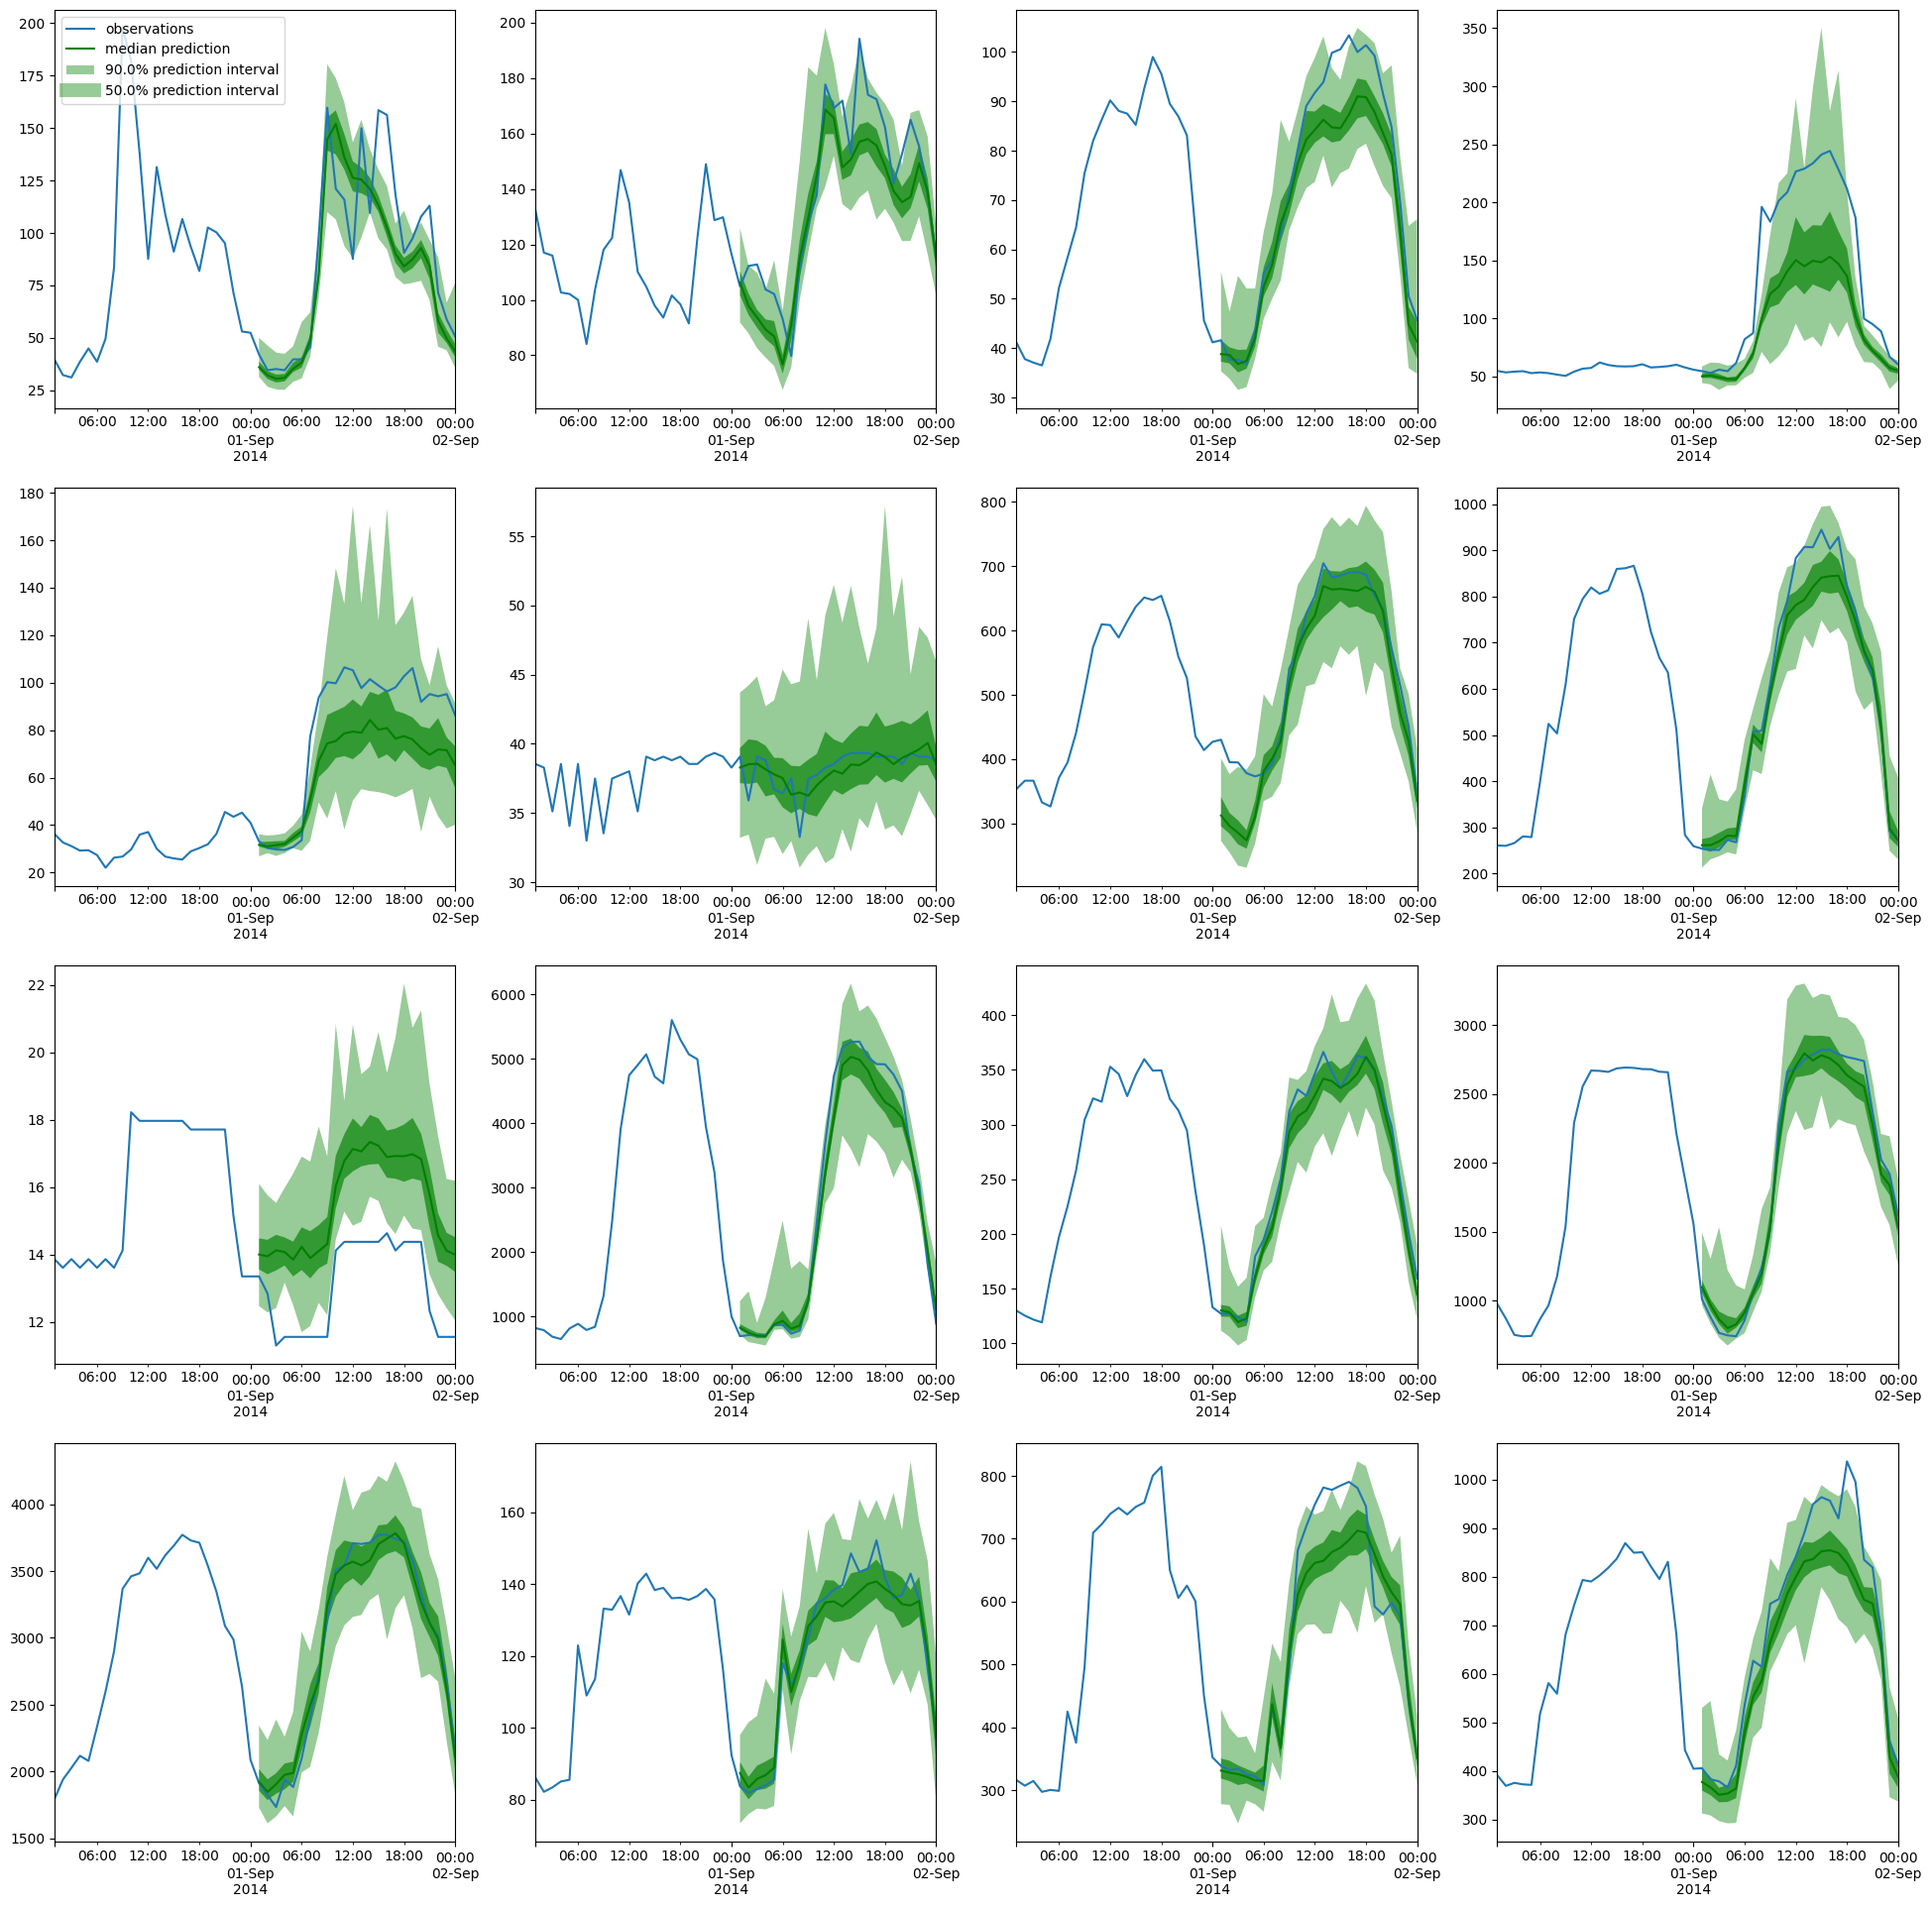

In [59]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=electricity.metadata.prediction_length,
)

plt.show()

### Solar

#### Train

In [93]:
# init scheduler
scheduler = DEISMultistepScheduler(num_train_timesteps=150, beta_end=0.1)

# init estimator
estimator = TimeGradEstimator(
    input_size=int(solar.metadata.feat_static_cat[0].cardinality),
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=100,
    prediction_length=solar.metadata.prediction_length,
    context_length=solar.metadata.prediction_length * 3,
    freq=solar.metadata.freq,
    scaling="mean",
    trainer_kwargs=dict(max_epochs=200, accelerator="gpu", devices="1"),
)

# train
predictor = estimator.train(
    solar_dataset_train, 
    cache_data=True, 
    shuffle_buffer_length=1024
    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type          | Params | In sizes                                                             | Out sizes        
-----------------------------------------------------------------------------------------------------------------------------------
0 | model | TimeGradModel | 186 K  | [[1, 1], [1, 1], [1, 72, 5], [1, 72, 137], [1, 72, 137], [1, 24, 5]] | [1, 100, 24, 137]
-----------------------------------------------------------------------------------------------------------------------------------
186 K     Trainable pa

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.35691 (best 0.35691), saving model to '/content/drive/MyDrive/lightning_logs/version_7/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 0.20671 (best 0.20671), saving model to '/content/drive/MyDrive/lightning_logs/version_7/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached 0.16952 (best 0.16952), saving model to '/content/drive/MyDrive/lightning_logs/version_7/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached 0.12367 (best 0.12367), saving model to '/content/drive/MyDrive/lightning_logs/version_7/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' reached 0.11206 (best 0.1120

In [94]:
# save model

torch.save(predictor, './reports/models/estimator__solar.ckpt')

#### Predict

In [98]:
# upload trained predictor
predictor = torch.load('./reports/models/estimator__solar.ckpt')

# init evaluator
evaluator = MultivariateEvaluator(
    quantiles=(np.arange(20) / 20.0)[1:], target_agg_funcs={"sum": np.sum}
)

# prediction
forecast_it, ts_it = make_evaluation_predictions(
    dataset=solar_dataset_test, predictor=predictor, num_samples=100
)

forecasts = list(forecast_it)
targets = list(ts_it)

# calculate metrics
agg_metric, _ = evaluator(
    targets, forecasts, num_series=len(solar_dataset_test)
    )

Running evaluation: 7it [00:00, 88.17it/s]
Running evaluation: 7it [00:00, 76.74it/s]
Running evaluation: 7it [00:00, 83.93it/s]
Running evaluation: 7it [00:00, 77.54it/s]
Running evaluation: 7it [00:00, 91.75it/s]
Running evaluation: 7it [00:00, 91.86it/s]
Running evaluation: 7it [00:00, 99.62it/s]
Running evaluation: 7it [00:00, 79.21it/s]
Running evaluation: 7it [00:00, 79.60it/s]
Running evaluation: 7it [00:00, 92.88it/s]
Running evaluation: 7it [00:00, 97.24it/s]
Running evaluation: 7it [00:00, 87.12it/s]
Running evaluation: 7it [00:00, 95.00it/s]
Running evaluation: 7it [00:00, 79.70it/s]
Running evaluation: 7it [00:00, 94.86it/s]
Running evaluation: 7it [00:00, 97.21it/s]
Running evaluation: 7it [00:00, 88.18it/s]
Running evaluation: 7it [00:00, 66.24it/s]
Running evaluation: 7it [00:00, 86.58it/s]
Running evaluation: 7it [00:00, 84.69it/s]
Running evaluation: 7it [00:00, 95.19it/s]
Running evaluation: 7it [00:00, 97.56it/s]
Running evaluation: 7it [00:00, 90.92it/s]
Running eva

#### Metrics

In [62]:
print("CRPS: {}".format(agg_metric["mean_wQuantileLoss"]))
print("ND: {}".format(agg_metric["ND"]))
print("NRMSE: {}".format(agg_metric["NRMSE"]))
print("MSE: {}".format(agg_metric["MSE"]))

CRPS: 0.4220444450633904
ND: 0.5121117319401458
NRMSE: 0.9885075394628364
MSE: 926.9104097695827


In [63]:
print("CRPS-Sum: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))
print("ND-Sum: {}".format(agg_metric["m_sum_ND"]))
print("NRMSE-Sum: {}".format(agg_metric["m_sum_NRMSE"]))
print("MSE-Sum: {}".format(agg_metric["m_sum_MSE"]))

CRPS-Sum: 0.3826077722096243
ND-Sum: 0.428002278383792
NRMSE-Sum: 0.7739749798120935
MSE-Sum: 10665292.880952382


#### Save results

In [99]:
# metrics
with open('reports/predictions/agg_metrics__solar.json', 'w') as fp:
    json.dump(agg_metric, fp)

# targets
with open('reports/predictions/targets__solar.pickle', 'wb') as handle:
    pickle.dump(targets, handle, protocol=pickle.HIGHEST_PROTOCOL)

# forecasts
with open('reports/predictions/forecasts__solar.pickle', 'wb') as handle:
    pickle.dump(forecasts, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Actual/forecast visualisation

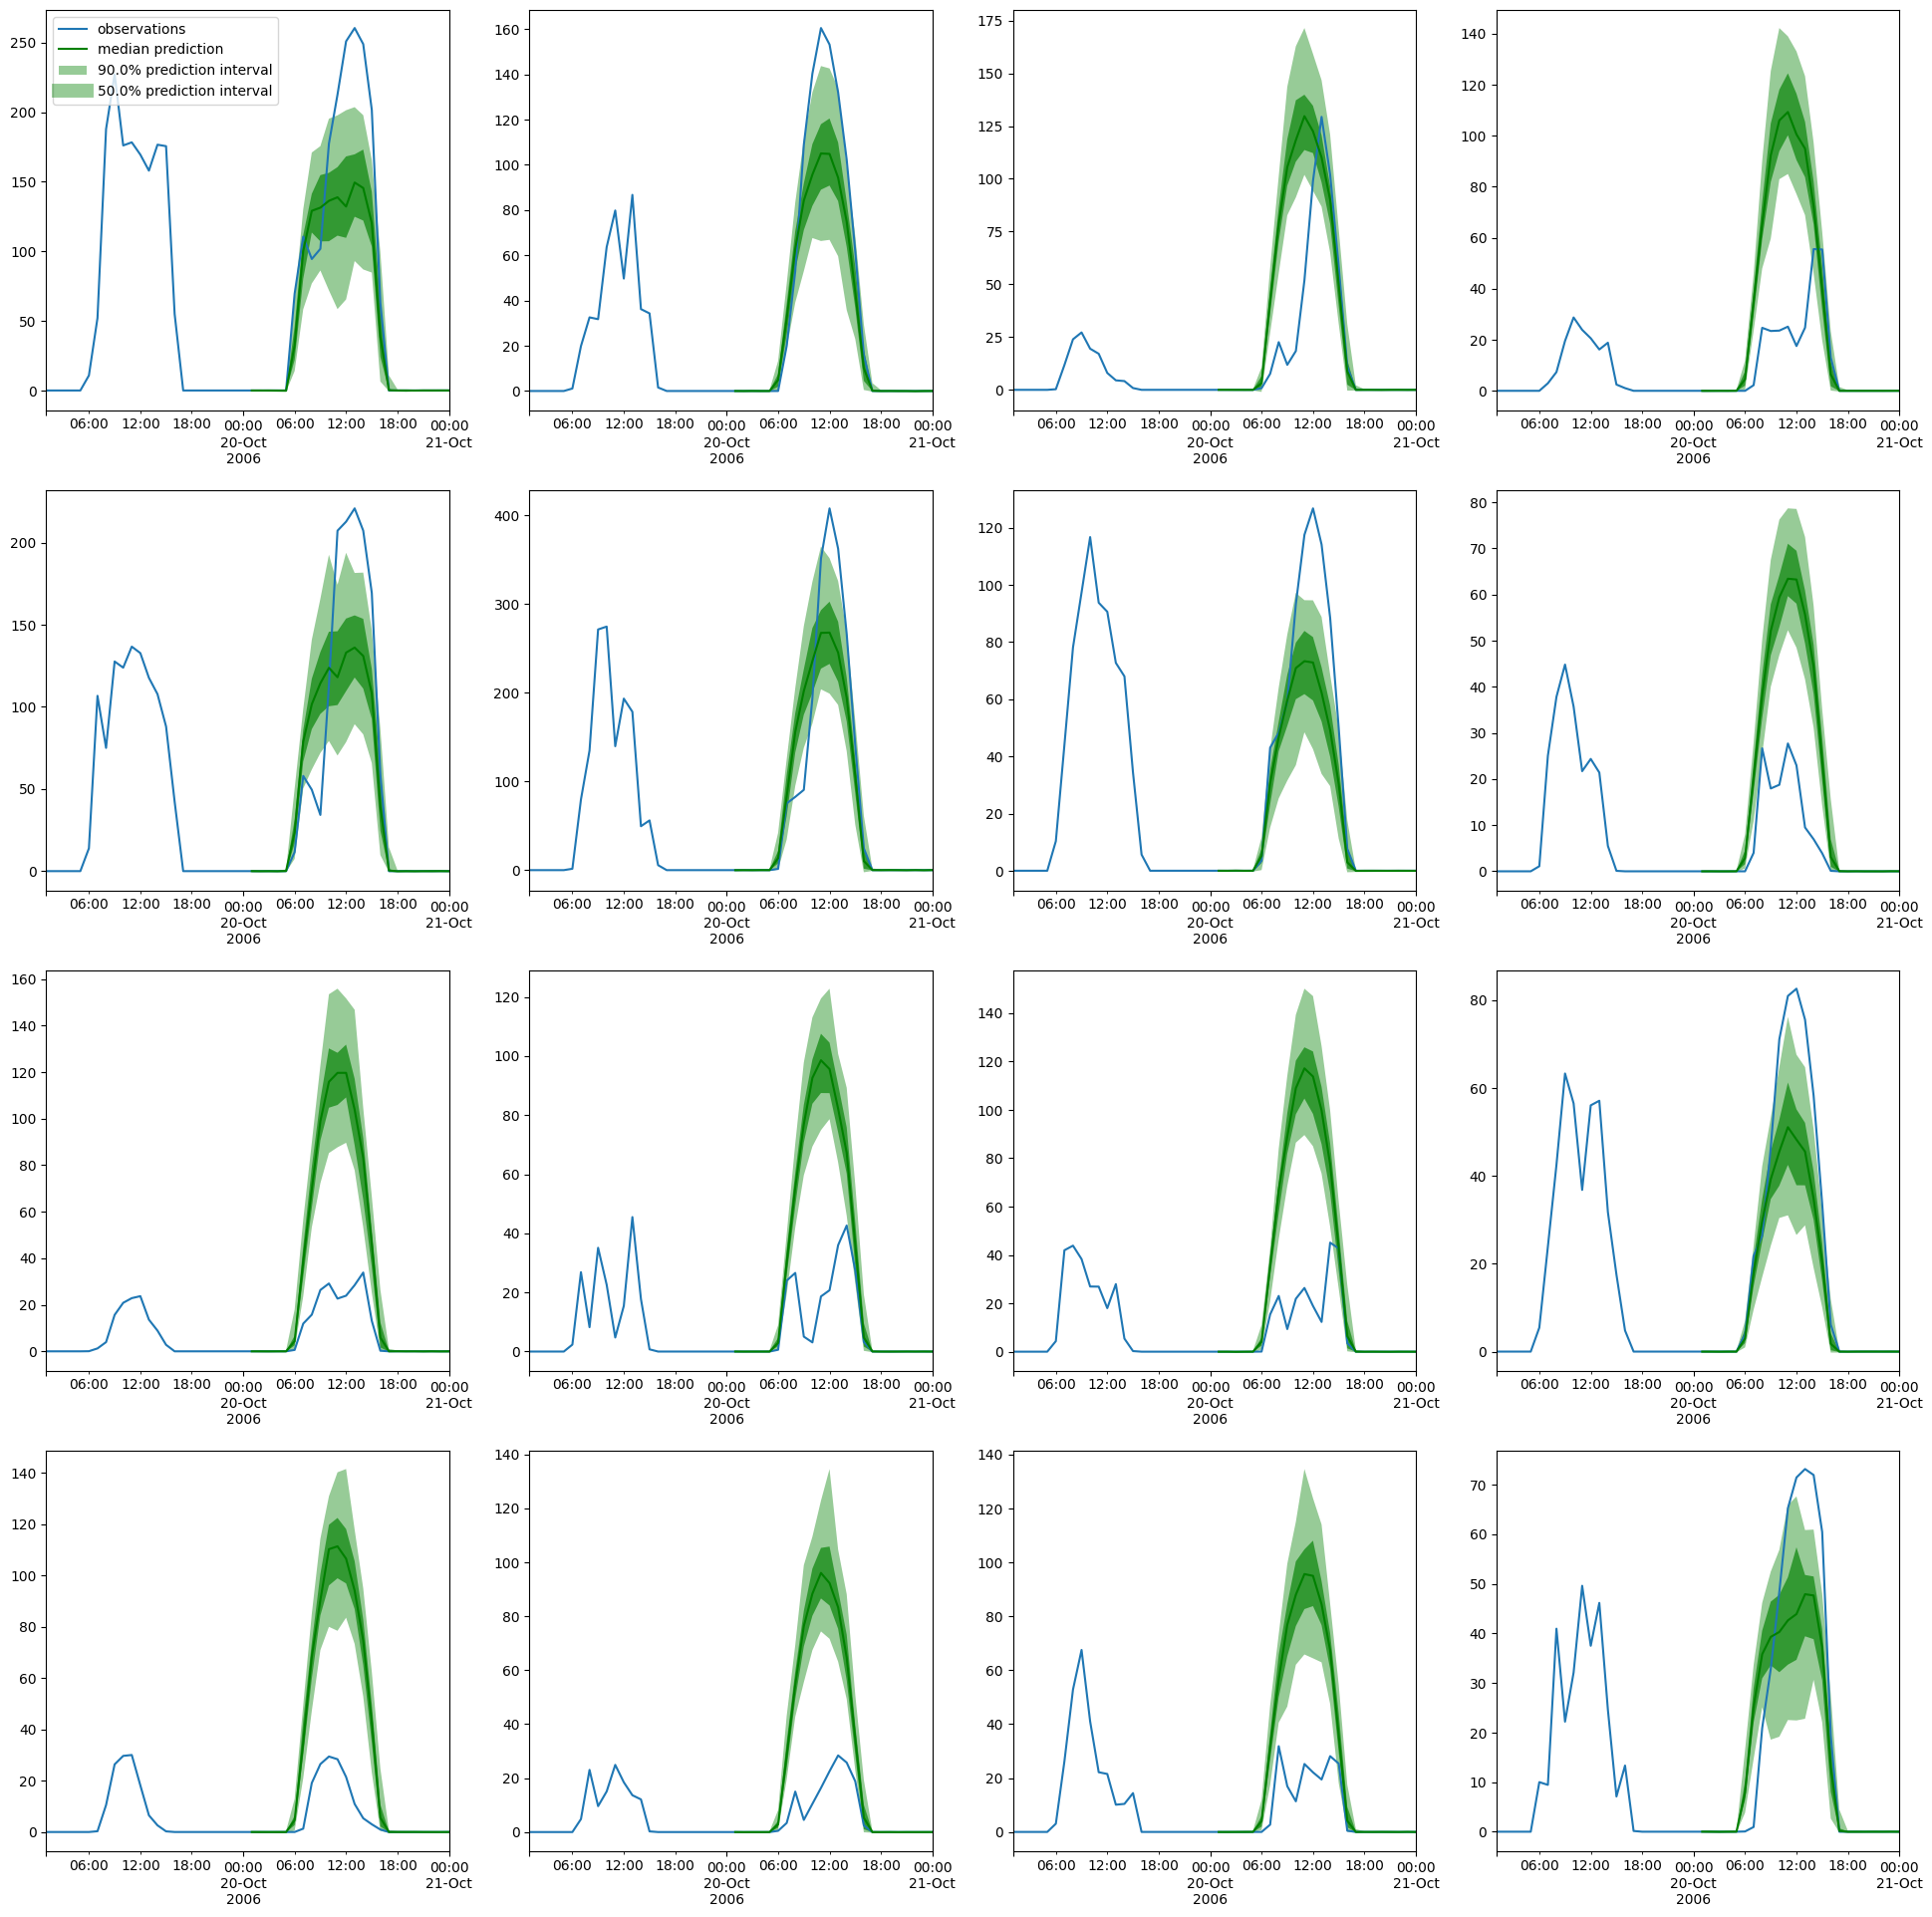

In [67]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=electricity.metadata.prediction_length,
)
plt.show()

### Exchange

#### Train

In [95]:
# init scheduler
scheduler = DEISMultistepScheduler(num_train_timesteps=150, beta_end=0.1)

# init estimator
estimator = TimeGradEstimator(
    input_size=int(exchange.metadata.feat_static_cat[0].cardinality),
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=100,
    prediction_length=exchange.metadata.prediction_length,
    context_length=exchange.metadata.prediction_length * 3,
    freq=exchange.metadata.freq,
    scaling="mean",
    trainer_kwargs=dict(max_epochs=200, accelerator="gpu", devices="1"),
)

# train
predictor = estimator.train(
    exchange_dataset_train, 
    cache_data=True, 
    shuffle_buffer_length=1024
    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type          | Params | In sizes                                                         | Out sizes      
-----------------------------------------------------------------------------------------------------------------------------
0 | model | TimeGradModel | 73.4 K | [[1, 1], [1, 1], [1, 90, 4], [1, 90, 8], [1, 90, 8], [1, 30, 4]] | [1, 100, 30, 8]
-----------------------------------------------------------------------------------------------------------------------------
73.4 K    Trainable params
0         Non-train

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.36461 (best 0.36461), saving model to '/content/drive/MyDrive/lightning_logs/version_8/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 0.19568 (best 0.19568), saving model to '/content/drive/MyDrive/lightning_logs/version_8/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached 0.13403 (best 0.13403), saving model to '/content/drive/MyDrive/lightning_logs/version_8/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached 0.10810 (best 0.10810), saving model to '/content/drive/MyDrive/lightning_logs/version_8/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' reached 0.09858 (best 0.0985

In [96]:
# save model

torch.save(predictor, './reports/models/estimator__exchange.ckpt')

#### Predicct

In [71]:
# upload trained predictor
predictor = torch.load('./reports/models/estimator__exchange.ckpt')

# init evaluator
evaluator = MultivariateEvaluator(
    quantiles=(np.arange(20) / 20.0)[1:], target_agg_funcs={"sum": np.sum}
)

# prediction
forecast_it, ts_it = make_evaluation_predictions(
    dataset=exchange_dataset_test, predictor=predictor, num_samples=100
)

forecasts = list(forecast_it)
targets = list(ts_it)

# calculate metrics
agg_metric, _ = evaluator(
    targets, forecasts, num_series=len(exchange_dataset_test)
    )

Running evaluation: 5it [00:00, 58.45it/s]
Running evaluation: 5it [00:00, 52.89it/s]
Running evaluation: 5it [00:00, 88.70it/s]
Running evaluation: 5it [00:00, 99.48it/s]
Running evaluation: 5it [00:00, 72.95it/s]
Running evaluation: 5it [00:00, 92.70it/s]
Running evaluation: 5it [00:00, 72.17it/s]
Running evaluation: 5it [00:00, 80.66it/s]
Running evaluation: 5it [00:00, 83.73it/s]


#### Metrics

In [72]:
print("CRPS: {}".format(agg_metric["mean_wQuantileLoss"]))
print("ND: {}".format(agg_metric["ND"]))
print("NRMSE: {}".format(agg_metric["NRMSE"]))
print("MSE: {}".format(agg_metric["MSE"]))

CRPS: 0.015963353698140125
ND: 0.02062834109534528
NRMSE: 0.032250851477007965
MSE: 0.0006880163205149378


In [73]:
print("CRPS-Sum: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))
print("ND-Sum: {}".format(agg_metric["m_sum_ND"]))
print("NRMSE-Sum: {}".format(agg_metric["m_sum_NRMSE"]))
print("MSE-Sum: {}".format(agg_metric["m_sum_MSE"]))

CRPS-Sum: 0.008577728097807696
ND-Sum: 0.011269480358263674
NRMSE-Sum: 0.014064065817235186
MSE-Sum: 0.008373713940382005


#### Save results

In [90]:
# metrics
with open('reports/predictions/agg_metrics__exchange.json', 'w') as fp:
    json.dump(agg_metric, fp)

# targets
with open('reports/predictions/targets__exchange.pickle', 'wb') as handle:
    pickle.dump(targets, handle, protocol=pickle.HIGHEST_PROTOCOL)

# forecasts
with open('reports/predictions/forecasts__exchange.pickle', 'wb') as handle:
    pickle.dump(forecasts, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Actual/forecast visualisation

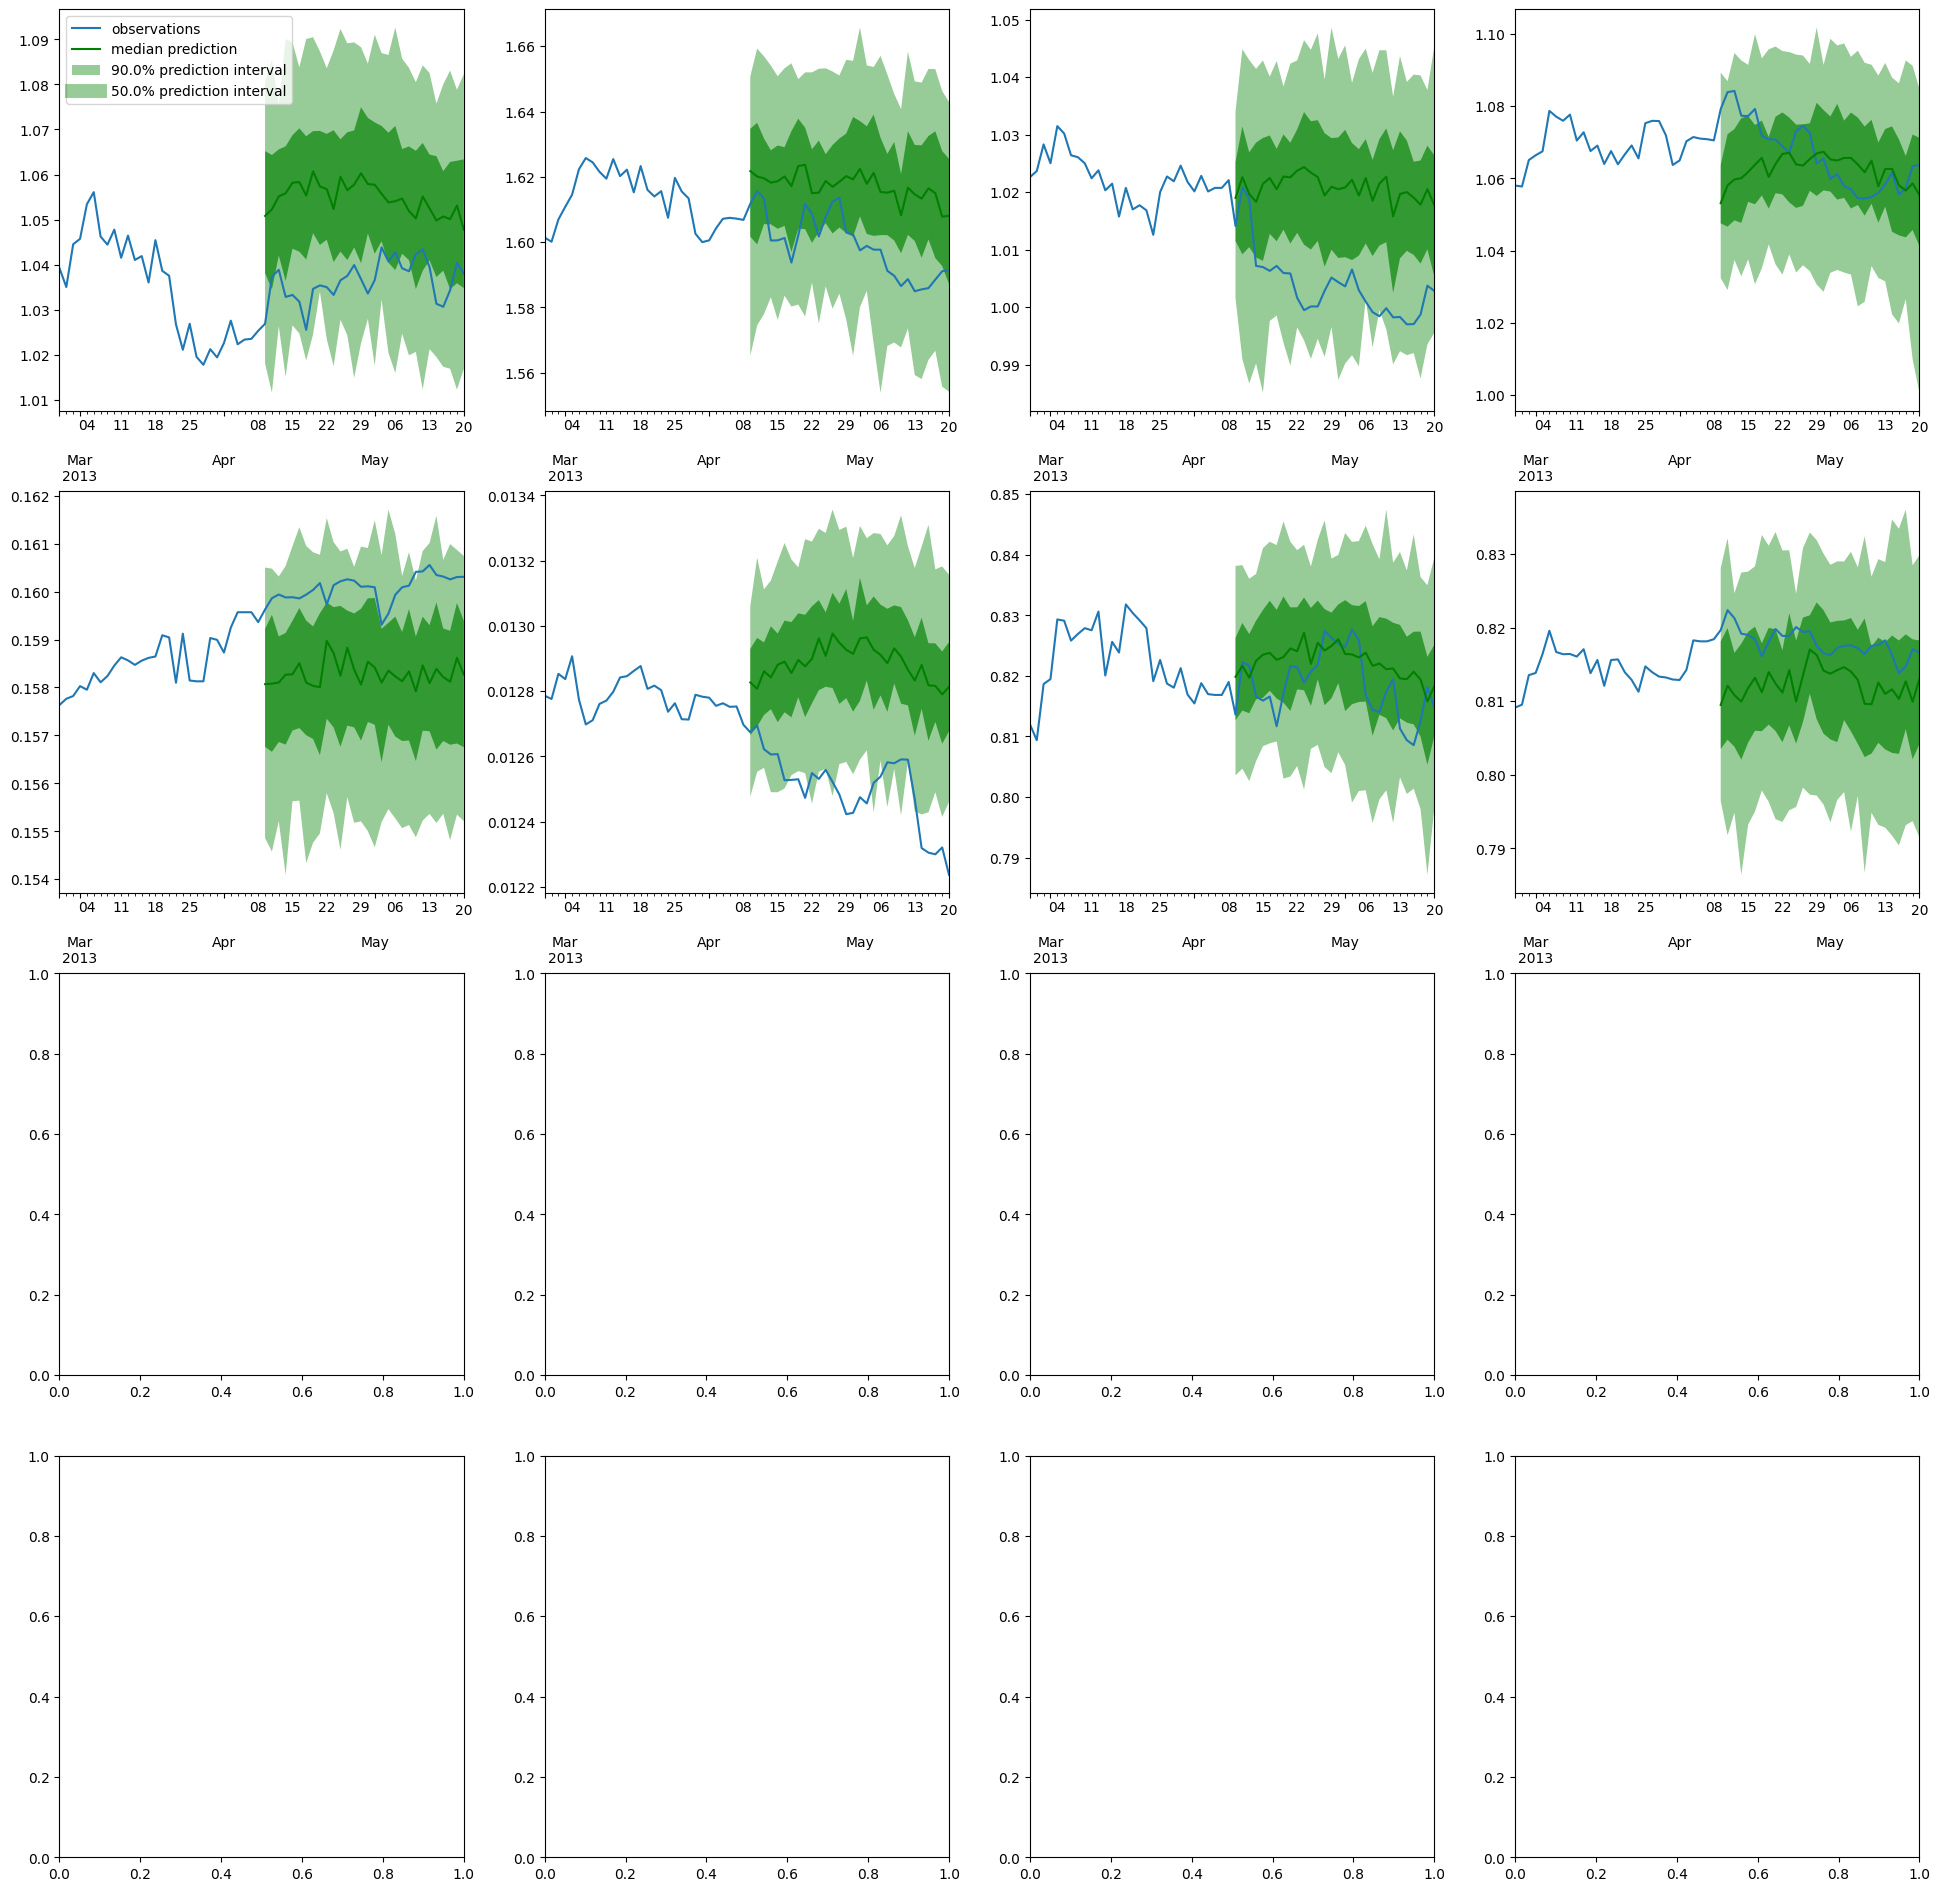

In [79]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=exchange.metadata.prediction_length,
)
plt.show()